In [1]:
confirmed_csv = "corona_confirmed.csv"
confirmed_gitpath = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

In [4]:
!curl -o $confirmed_csv $confirmed_gitpath 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 1777k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1777k  100 1777k    0     0  1801k      0 --:--:-- --:--:-- --:--:-- 1802k


In [5]:
import pandas as pd
df = pd.read_csv(confirmed_csv)

df = df.melt(id_vars=["Province/State","Country/Region","Lat","Long"],
                var_name="DateColumns",
                value_name="CasesColumns")

df['DateColumns'] = pd.to_datetime(df['DateColumns'], format='%m/%d/%y').dt.strftime('%Y-%m-%d')
df["Province/State"] = df["Province/State"].fillna(df["Country/Region"])
df['DateColumns'] = pd.to_datetime(df['DateColumns'])
df["CasesColumns"] = df["CasesColumns"].astype(int)

#
#
df['Lat'].fillna(df['Lat'].mean(), inplace=True)
df['Long'].fillna(df['Long'].mean(), inplace=True)
#54. Derste hata olarak bahsettiğim ve çözümünü böyle bulduğumu söylediğim şeyi burada bir daha yazıyorum
# herhangi bir hatayla karşılaşmamak için

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330327 entries, 0 to 330326
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Province/State  330327 non-null  object        
 1   Country/Region  330327 non-null  object        
 2   Lat             330327 non-null  float64       
 3   Long            330327 non-null  float64       
 4   DateColumns     330327 non-null  datetime64[ns]
 5   CasesColumns    330327 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), object(2)
memory usage: 13.9+ MB


In [9]:
burning_counteries = df.groupby("Country/Region")["CasesColumns"].max().sort_values(ascending=False).reset_index()
#burning_counteries_lts = [*burning_counteries["Country/Region"]][:9]
#burning_counteries_lts.insert(-1,"Turkey")
burning_counteries_lts = [*burning_counteries["Country/Region"]][:10]
burning_counteries_lts

['US',
 'India',
 'France',
 'Germany',
 'Brazil',
 'Japan',
 'Korea, South',
 'Italy',
 'United Kingdom',
 'Russia']

In [14]:
df_burning_counteries = burning_counteries[burning_counteries["Country/Region"].isin(burning_counteries_lts)].reset_index(drop = "True")
df_burning_counteries["Country/Region"] = df_burning_counteries["Country/Region"].str.replace(",", "")
df_burning_counteries

,Country/Region,CasesColumns
0,US,103802702
1,India,44690738
2,France,38618509
3,Germany,38249060
4,Brazil,37081209
5,Japan,33320438
6,Korea South,30615522
7,Italy,25603510
8,United Kingdom,24425309
9,Russia,22075858


In [65]:
burning_counteries_daily = df.groupby(["DateColumns","Country/Region"])["CasesColumns"].max().sort_values(ascending=False).reset_index()
burning_counteries_daily = burning_counteries_daily[burning_counteries_daily["Country/Region"].isin(burning_counteries_lts)].reset_index(drop = "True")
burning_counteries_daily["Country/Region"] = burning_counteries_daily["Country/Region"].str.replace(",","")
burning_counteries_daily

,DateColumns,Country/Region,CasesColumns
0,2023-03-09,US,103802702
1,2023-03-08,US,103755771
2,2023-03-07,US,103690910
3,2023-03-06,US,103655539
4,2023-03-04,US,103650837
...,...,...,...
11425,2020-02-18,Brazil,0
11426,2020-02-17,Brazil,0
11427,2020-02-20,Brazil,0
11428,2020-02-21,Brazil,0


In [19]:
import random
colors = dict(zip(
    [*set(df_burning_counteries["Country/Region"])],
    ["#"+"".join([random.choice("0123456789ABCDEF") for j in range(6)])
        for i in set(df_burning_counteries["Country/Region"])]))
colors_df = pd.DataFrame.from_dict(colors, orient="index")
colors_df

,0
Korea South,#4BF7C4
US,#DBA936
France,#0F6CB3
Germany,#78D2B9
Japan,#C817E2
Russia,#5215CB
Italy,#64E49F
Brazil,#19822D
United Kingdom,#A8DFD5
India,#2F92D5


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animaton
from IPython.display import HTML

In [80]:
def chart(date):
    dff = burning_counteries_daily[burning_counteries_daily["DateColumns"].eq(date)].sort_values(by='CasesColumns', ascending=True).tail(10)
    ax.clear()
    ax.barh(dff['Country/Region'], dff['CasesColumns'], color=[colors_df.loc[x][0] for x in dff['Country/Region']])
    dx = dff['CasesColumns'].max() / 200
    for i, (value, name) in enumerate(zip(dff['CasesColumns'], dff['Country/Region'])):
        ax.text(-1*(dx+5), i, name, size=12, weight=600, ha='right', va='center', color="white", bbox=dict(facecolor="blue", alpha=0.5, pad=12))
        ax.text(value+dx+5, i, f'{value:,.0f}', size=12, ha='left', va='center', color="white", bbox=dict(facecolor="red", alpha=0.5, pad=12))
    ax.text(1, 0.4, str(date)[:10], transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Vaka Sayisi', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.15, 'Dünya Genelinde Korona Vakaları',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    plt.box(False)

**************************************************************************************************************


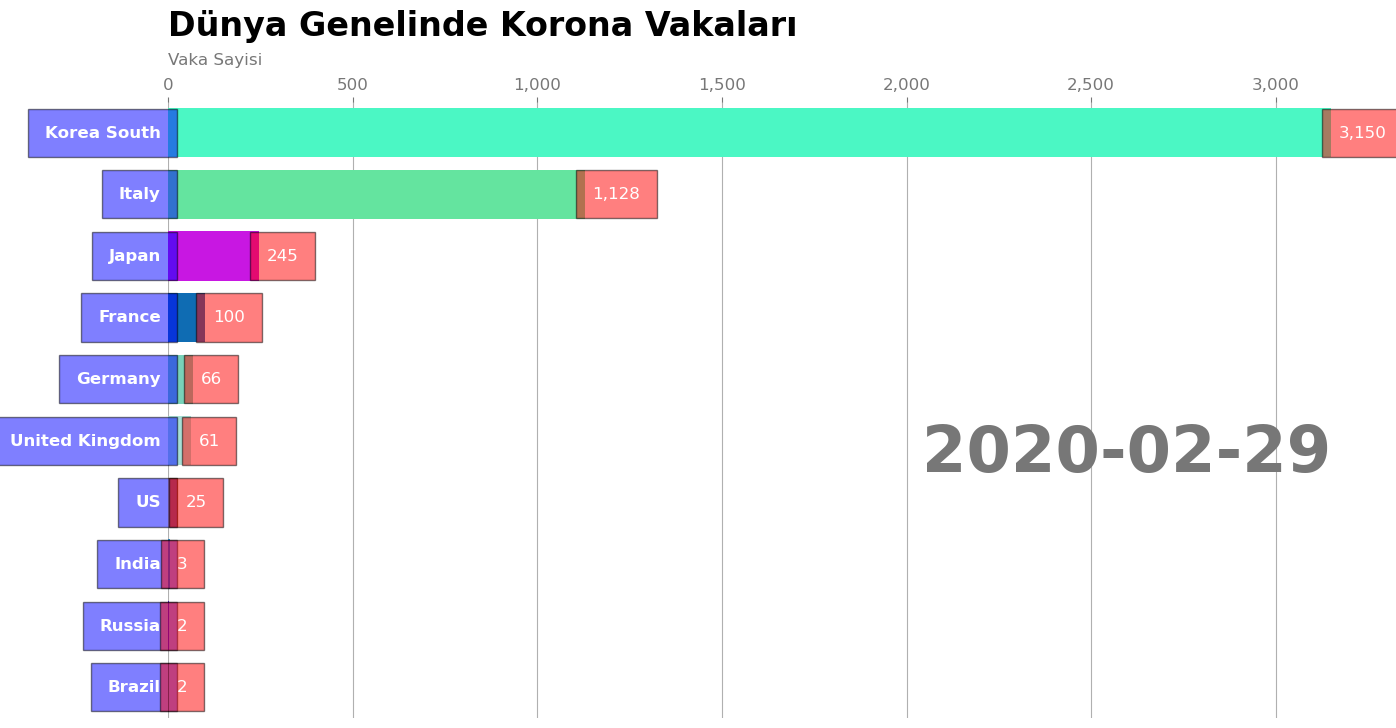

In [81]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
fig, ax = plt.subplots(figsize=(15,8))
print("*"*110)
start_date = pd.to_datetime('2020-02-01')
end_date = df["DateColumns"].max()
ts_index = pd.date_range(start=start_date, end=end_date, freq="M")
#2020-02-01 den başlatıyorum saymaya çünkü ilk veriler bozuk gibi gözüküyordu
animator = animaton.FuncAnimation(fig,chart,frames=[*ts_index])
HTML(animator.to_jshtml())

